# Diffusion Schrodinger Bridge Matching

Diffusion Schrodinger Bridge Matching, Shi et al., 2023.

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

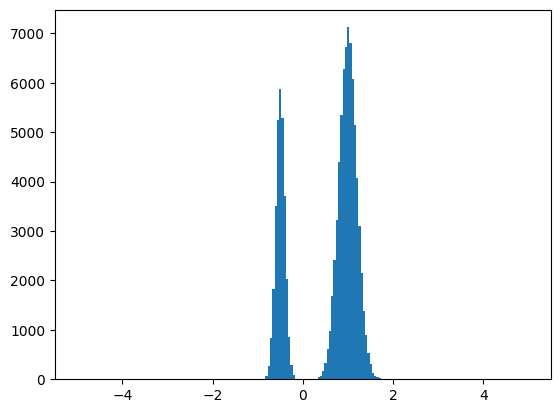

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as D

mixture = D.MixtureSameFamily(
    D.Categorical(torch.tensor([0.3, 0.7])),
    D.Normal(torch.tensor([-0.5, 1.0]), torch.tensor([0.1, 0.2])),
)
# target distribution
X = mixture.sample((100000, 1))

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Model

Define MLP backbone and DSBM training framework.

In [2]:
import torch
import torch.nn as nn

from flowmodels import DiffusionSchrodingerBridgeMatching


class Backbone(nn.Module):
    def __init__(self, dim: int = 1, layers: int = 3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            *[
                submodule
                for _ in range(layers)
                for submodule in (nn.ReLU(), nn.Linear(64, 64))
            ],
            nn.ReLU(),
            nn.Linear(64, dim),
        )

    def forward(self, x_t: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.net.forward(torch.cat([x_t, t[:, None].to(x_t)], dim=-1))


model = DiffusionSchrodingerBridgeMatching(Backbone())
model

DiffusionSchrodingerBridgeMatching(
  (fwd): Backbone(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (bwd): Backbone(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

## 3. Train DSBM

Train the DSBM with the prepared dataset.

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

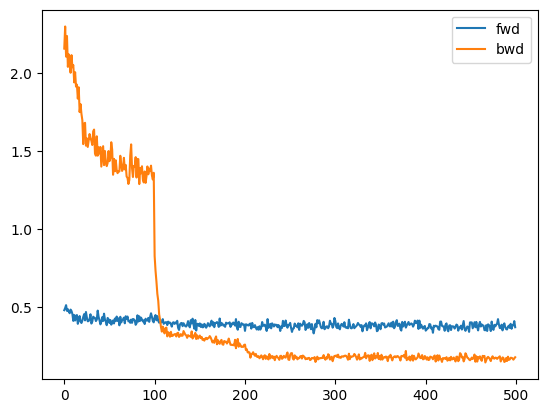

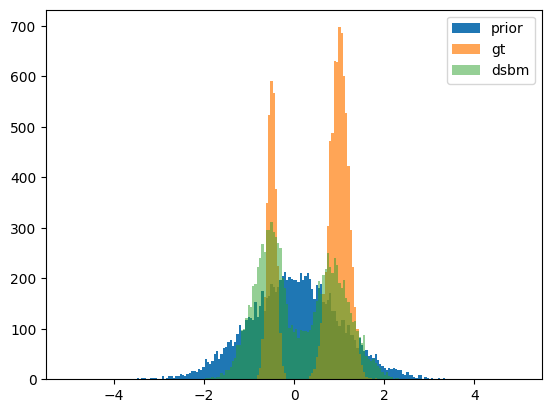

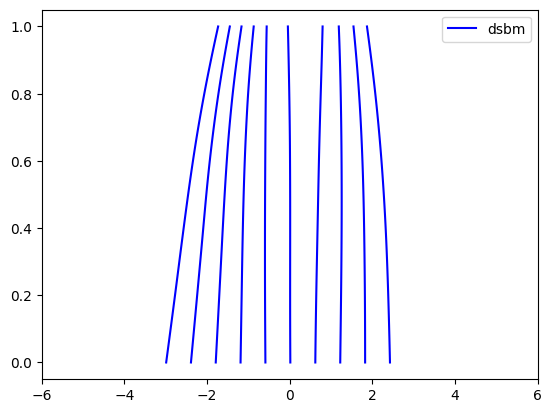

In [3]:
import torch
from tqdm.auto import tqdm


# training configurations
LR = 0.001
TRAIN_STEPS = 100
OUTER_STEPS = 10
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)
losses = model.imf(
    x_0=X,
    x_1=torch.randn_like(X),
    optim=optim,
    batch_size=BATCH_SIZE,
    inner_steps=TRAIN_STEPS,
    outer_steps=OUTER_STEPS,
    steps=20,
    verbose=lambda r: tqdm(r, leave=False),
)

plt.plot(
    [loss for unit in losses if unit["direction"] == "fwd" for loss in unit["losses"]],
    label="fwd",
)
plt.plot(
    [loss for unit in losses if unit["direction"] == "bwd" for loss in unit["losses"]],
    label="bwd",
)
plt.legend()

# plot histogram
n = 10000
sample = torch.randn(n, X.shape[-1])
with torch.inference_mode():
    x_t, _ = model.sample(sample, verbose=lambda x: tqdm(x, leave=False), steps=100)

plt.figure()
plt.hist(sample, bins=np.linspace(-5, 5, 200), label="prior")
plt.hist(X[:n], bins=np.linspace(-5, 5, 200), label="gt", alpha=0.7)
plt.hist(x_t.view(-1), bins=np.linspace(-5, 5, 200), label="dsbm", alpha=0.5)
plt.legend()
_xticks, _ = plt.xticks()

# plot trajectory
n = 200
with torch.inference_mode():
    _, x_ts = model.sample(torch.linspace(-3, 3, n)[:, None], steps=100)

plt.figure()
for i in range(10):
    plt.plot(
        torch.tensor([_x_t[i * 20].item() for _x_t in x_ts]),
        np.linspace(0, 1, len(x_ts)),
        "b",
        **({} if i > 0 else {"label": "dsbm"}),  # labeling on first plot only
    )
    plt.xticks(_xticks)
plt.legend()